In [2]:
# notebook for analyzing qPCR for UKBB/GTEx Base Editing Experiments #


In [3]:
# import packages
import pandas as pd
import matplotlib.pyplot as mpl
import seaborn as sns
from scipy import stats
import matplotlib
import numpy as np
import os


In [ ]:
data_dir="/Users/tewher/Google_Drive_JAX/Manuscripts/2023_UKBB-BBJ-GTEx_MPRA/2023_UKBB_GTEx_MPRA_Manuscript/Data"

import pandas as pd
import numpy as np
import os
from pathlib import Path

# Define sample annotations
SAMPLE_ANNOTATIONS = {
    'GT_BE_013': 'Base Edited',
    'GT_BE_022': 'Base Edited',
    'GT_BE_026': 'Base Edited',
    'GT_BE_042': 'Base Edited',
    'GT_BE_050': 'Base Edited',
    'GT_BE_061': 'Base Edited',
    'GT_BE_070': 'Base Edited',
    'GT_BE_087': 'Base Edited',
    'GT_BE_088': 'Base Edited',
    'GT_BE_001': 'Reference',
    'GT_BE_007': 'Reference',
    'GT_BE_028': 'Reference',
    'GT_BE_029': 'Reference',
    'GT_BE_030': 'Reference',
    'GT_BE_032': 'Reference',
    'GT_BE_035': 'Reference',
    'GT_BE_036': 'Reference',
    'GT_BE_038': 'Reference',
    'GT_BE_039': 'Reference',
    'GT_BE_041': 'Reference'
}

def read_excel_data(excel_file, iqr_factor=3, max_ct_diff=1.0):
    """
    Read data from Excel file and extract relevant columns with robust outlier detection
    
    Parameters:
    excel_file: Path to Excel file
    iqr_factor: Factor to multiply IQR for outlier detection (default: 1.5)
    max_ct_diff: Maximum allowed CT difference from median (default: 1.0)
    """
    # Read the Excel file
    df = pd.read_excel(excel_file, sheet_name="Results")
    
    # Find the row that starts with "Well" (header row)
    header_row = df[df.iloc[:, 0] == "Well"].index[0]
    
    # Get data starting after the header row
    data = df.iloc[header_row+1:].copy()
    data.columns = df.iloc[header_row]
    
    file_name = os.path.basename(excel_file)
    
    # Keep Well column for reporting
    result = data[["Well", "Sample Name", "Target Name", "CT"]].copy()
    
    # Convert numerical columns
    result["Well"] = pd.to_numeric(result["Well"], errors="coerce")
    result["CT"] = pd.to_numeric(result["CT"], errors="coerce")
    
    # Drop rows with missing values
    result = result.dropna()
    
    # Filter to keep only samples that are Reference or Base Edited
    # First, add the Sample Status
    result["Sample Status"] = result["Sample Name"].map(
        lambda x: SAMPLE_ANNOTATIONS.get(x, "Unknown")
    )
    
    # Keep only Reference or Base Edited samples
    result = result[result["Sample Status"].isin(["Reference", "Base Edited"])]
    
    # Perform robust outlier detection
    print(f"\nChecking for outliers in {file_name}:")
    outliers_removed = 0
    
    # Group by Sample Name and Target Name
    for (sample, target), group in result.groupby(["Sample Name", "Target Name"]):
        # Only check for outliers if we have at least 3 replicates
        if len(group) >= 3:
            # Get CT values and well numbers
            ct_values = group["CT"].values
            wells = group["Well"].values
            
            # Calculate robust statistics
            median_ct = np.median(ct_values)
            q1 = np.percentile(ct_values, 25)
            q3 = np.percentile(ct_values, 75)
            iqr = q3 - q1
            
            # Define outlier thresholds - using both IQR and absolute difference
            lower_bound = q1 - iqr_factor * iqr
            upper_bound = q3 + iqr_factor * iqr
            
            # Identify outliers - points that are either far from the IQR or differ too much from median
            for i, (ct, well) in enumerate(zip(ct_values, wells)):
                is_iqr_outlier = ct < lower_bound or ct > upper_bound
                is_absolute_outlier = abs(ct - median_ct) > max_ct_diff
                
                if is_iqr_outlier or is_absolute_outlier:
                    outlier_idx = group.iloc[i].name
                    outlier_type = "IQR" if is_iqr_outlier else "Abs Diff"
                    
                    print(f"  Removing outlier: Well={int(well)}, Sample={sample}, Target={target}, " +
                          f"CT={ct:.4f}, Median={median_ct:.4f}, Diff={abs(ct-median_ct):.4f}, Type={outlier_type}")
                    
                    # Remove the outlier
                    result = result.drop(outlier_idx)
                    outliers_removed += 1
    
    if outliers_removed == 0:
        print(f"  No outliers detected in {file_name}")
    else:
        print(f"  Removed {outliers_removed} outlier(s) from {file_name}")
    
    # Drop the Well and Sample Status columns (they were just for reporting)
    result = result.drop(columns=["Well", "Sample Status"])
    
    return result

def calculate_means(df):
    """Calculate mean CT values for each Sample Name and Target Name"""
    # Group by Sample Name and Target Name and calculate mean CT
    means = df.groupby(["Sample Name", "Target Name"])["CT"].mean().reset_index()
    means = means.rename(columns={"CT": "Mean CT"})
    return means

def add_annotations(means_df):
    """Add sample annotations to the dataframe"""
    # Create a new column for annotations
    means_df['Sample Status'] = means_df['Sample Name'].map(
        lambda x: SAMPLE_ANNOTATIONS.get(x, "Unknown")
    )
    return means_df

def calculate_tbp_subtracted(means_df):
    """Calculate TBP subtracted values for each sample"""
    # Create a pivot table with Sample Name as index and Target Name as columns
    pivot = means_df.pivot(index="Sample Name", columns="Target Name", values="Mean CT")
    
    # Extract TBP values
    tbp_values = pivot["TBP"].copy()
    
    # Calculate TBP subtracted values for HIBCH and c2orf88
    result_df = pd.DataFrame(index=pivot.index)
    result_df["Sample Name"] = pivot.index
    
    # Add annotations
    result_df["Sample Status"] = result_df["Sample Name"].map(
        lambda x: SAMPLE_ANNOTATIONS.get(x, "Unknown")
    )
    
    for target in ["HIBCH_F1_R1", "c2orf88_F2_R1"]:
        if target in pivot.columns:
            result_df[f"{target} - TBP"] = pivot[target] - tbp_values
    
    return result_df

def calculate_reference_normalized(tbp_subtracted_df):
    """Normalize to the average of reference samples"""
    # Create a copy of the input dataframe
    result_df = tbp_subtracted_df.copy()
    
    # Extract reference samples
    ref_samples = result_df[result_df["Sample Status"] == "Reference"]
    
    # Calculate average TBP-subtracted values for reference samples
    ref_means = {}
    for target in ["HIBCH_F1_R1", "c2orf88_F2_R1"]:
        col_name = f"{target} - TBP"
        if col_name in ref_samples.columns:
            ref_means[col_name] = ref_samples[col_name].mean()
    
    # Subtract reference means from all samples
    for target in ["HIBCH_F1_R1", "c2orf88_F2_R1"]:
        col_name = f"{target} - TBP"
        ref_norm_col = f"{target} - TBP (Ref Norm)"
        if col_name in result_df.columns and col_name in ref_means:
            result_df[ref_norm_col] = result_df[col_name] - ref_means[col_name]
    
    return result_df

def create_final_report(all_results, output_dir, output_options):
    """Create a final report with results from all files and 2^-X averaging"""
    # Get all sample names from all files
    all_samples = set()
    for file_id in all_results:
        all_samples.update(all_results[file_id]["ref_normalized"]["Sample Name"])
    
    # Create a DataFrame for each target
    target_dfs = {}
    for target in ["HIBCH_F1_R1", "c2orf88_F2_R1"]:
        target_df = pd.DataFrame()
        target_df["Sample Name"] = sorted(list(all_samples))
        
        # Add sample status
        target_df["Group"] = target_df["Sample Name"].map(
            lambda x: SAMPLE_ANNOTATIONS.get(x, "Unknown")
        )
        
        # Add Target column - removing the suffix (like _F1_R1)
        # Use a simple string split approach instead of regex
        if "_F" in target:
            simplified_target = target.split("_F")[0]
        else:
            simplified_target = target
        target_df["Target Name"] = simplified_target
        
        # Add data from each file
        for file_id in sorted(all_results.keys()):
            ref_norm_df = all_results[file_id]["ref_normalized"]
            col_name = f"{target} - TBP (Ref Norm)"
            
            if col_name in ref_norm_df.columns:
                # Create a mapping from sample name to value
                value_map = dict(zip(ref_norm_df["Sample Name"], ref_norm_df[col_name]))
                
                # Add values for this file
                file_col_name = f"{col_name} ({file_id})"
                target_df[file_col_name] = target_df["Sample Name"].map(
                    lambda x: value_map.get(x, np.nan)
                )
                
                # Calculate and add 2^-X for this file
                power_col_name = f"2^-({file_col_name})"
                target_df[power_col_name] = np.power(2, -target_df[file_col_name])
        
        # Calculate average of 2^-X values across files
        power_columns = [col for col in target_df.columns if col.startswith("2^-(")]
        
        if power_columns:
            # Calculate average 2^-X
            target_df["avg FC"] = target_df[power_columns].mean(axis=1)
            
            # For debugging/verification
            if target == "c2orf88_F2_R1" and "GT_BE_013" in target_df["Sample Name"].values:
                sample_row = target_df[target_df["Sample Name"] == "GT_BE_013"]
                if not sample_row.empty:
                    print("\nVerification for GT_BE_013, c2orf88:")
                    for col in power_columns:
                        print(f"  {col}: {sample_row[col].values[0]}")
                    print(f"  Average FC: {sample_row['avg FC'].values[0]}")
        
        target_dfs[target] = target_df
    
    # Save each target dataframe separately (for reference)
    if output_options["target_reports"]:
        for target, df in target_dfs.items():
            # Keep important columns for output
            cols_to_keep = ["Sample Name", "Group", "Target Name"]
            # Add Delta Delta Ct columns
            cols_to_keep.extend([col for col in df.columns if col.startswith(f"{target} - TBP (Ref Norm) (File")])
            # Add 2^-X columns
            cols_to_keep.extend([col for col in df.columns if col.startswith(f"2^-(")])
            # Add average column
            cols_to_keep.append("avg FC")
            
            # Select only the columns we want to keep
            output_df = df[cols_to_keep]
            
            # Get simplified target name for filename
            if "_F" in target:
                simplified_target = target.split("_F")[0]
            else:
                simplified_target = target
            
            output_path = Path(output_dir) / f"final_report_{simplified_target}.tsv"
            output_df.to_csv(output_path, sep="\t", index=False)
            print(f"  - Saved final report for {simplified_target} to {output_path}")
    
    # Create a single combined report with both targets
    if output_options["final_simplified"]:
        # Combine the dataframes for each target
        combined_df = pd.concat([target_dfs[target] for target in target_dfs], ignore_index=True)
        
        # Keep only essential columns with the requested names
        simplified_df = combined_df[["Sample Name", "Group", "Target Name", "avg FC"]].copy()
        
        # Save simplified combined report
        output_path = Path(data_dir+"/Editing/") / "final_qPCR_report_gata_luna.tsv"
        simplified_df.to_csv(output_path, sep="\t", index=False)
        print(f"  - Saved simplified final report to {data_dir+"/Editing/"}")
    
    return target_dfs



In [5]:
file_paths = [
        data_dir+"/Editing/jb_03_18_25_gata_tal_luna_v2.xls",
        data_dir+"/Editing/jb_03_20_25_gata_tal_luna_v2.xls",
        # Add more files here as needed
        # "file3.xls",
        # "file4.xls",
    ]
    
# Specify output directory
output_dir = "results"
    
# Output file control - set to True/False to enable/disable specific output files
output_options = {
    "means": False,                    # Mean CT values for each file
    "tbp_subtracted": False,           # TBP-subtracted values for each file
    "reference_normalized": False,     # Reference-normalized values for each file
    "target_reports": False,           # Individual reports for each target
    "final_simplified": True          # Final simplified report with all targets
}
    
# Set outlier detection parameters
iqr_factor = 4  # Factor to multiply IQR for outlier detection
max_ct_diff = 1.0  # Maximum allowed CT difference from median
    
# Process the files with robust outlier detection
print(f"Processing files with robust outlier detection (IQR factor: {iqr_factor}, Max CT diff: {max_ct_diff})...")
    
# Dictionary to store the processed data for each file
all_results = {}
    
# Process each file individually
for i, file_path in enumerate(file_paths):
    file_id = f"File{i+1}"
    file_name = Path(file_path).name
    print(f"\nProcessing {file_name} as {file_id}...")
        
    # Read the Excel file and calculate means
    raw_data = read_excel_data(file_path, iqr_factor, max_ct_diff)
    means_data = calculate_means(raw_data)
    means_data = add_annotations(means_data)
        
    # Create output directory if it doesn't exist
    Path(output_dir).mkdir(parents=True, exist_ok=True)
        
    # Save the means data if enabled
    if output_options["means"]:
        means_output_path = Path(output_dir) / f"{file_id}_means.tsv"
        means_data.to_csv(means_output_path, sep="\t", index=False)
        print(f"  - Saved means data to {means_output_path}")
        
    # Calculate TBP subtracted values
    tbp_subtracted = calculate_tbp_subtracted(means_data)
        
    # Save TBP subtracted values if enabled
    if output_options["tbp_subtracted"]:
        tbp_output_path = Path(output_dir) / f"{file_id}_tbp_subtracted.tsv"
        tbp_subtracted.to_csv(tbp_output_path, sep="\t", index=False)
        print(f"  - Saved TBP subtracted data to {tbp_output_path}")
        
    # Calculate reference normalized values
    ref_normalized = calculate_reference_normalized(tbp_subtracted)
        
    # Save reference normalized values if enabled
    if output_options["reference_normalized"]:
        ref_output_path = Path(output_dir) / f"{file_id}_reference_normalized.tsv"
        ref_normalized.to_csv(ref_output_path, sep="\t", index=False)
        print(f"  - Saved reference normalized data to {ref_output_path}")
        
    # Store results for this file
    all_results[file_id] = {
        "means": means_data,
        "tbp_subtracted": tbp_subtracted,
        "ref_normalized": ref_normalized
    }
    
    # Create combined file with all results if enabled
if len(file_paths) >= 2:
    create_final_report(all_results, output_dir, output_options)
    
print(f"\nAll analysis complete. Results saved to '{output_dir}'")
    
if output_options["final_simplified"]:
    print(f"Final simplified report is available at '{data_dir+"/Editing/"}/final_qPCR_report_gata_luna.tsv'")

Processing files with robust outlier detection (IQR factor: 4, Max CT diff: 1.0)...

Processing jb_03_18_25_gata_tal_luna_v2.xls as File1...

Checking for outliers in jb_03_18_25_gata_tal_luna_v2.xls:
  Removing outlier: Well=61, Sample=GT_BE_001, Target=c2orf88_F2_R1, CT=33.6471, Median=29.0269, Diff=4.6202, Type=Abs Diff
  Removing outlier: Well=133, Sample=GT_BE_013, Target=c2orf88_F2_R1, CT=30.2967, Median=29.0882, Diff=1.2085, Type=Abs Diff
  Removed 2 outlier(s) from jb_03_18_25_gata_tal_luna_v2.xls

Processing jb_03_20_25_gata_tal_luna_v2.xls as File2...

Checking for outliers in jb_03_20_25_gata_tal_luna_v2.xls:
  No outliers detected in jb_03_20_25_gata_tal_luna_v2.xls

Verification for GT_BE_013, c2orf88:
  2^-(c2orf88_F2_R1 - TBP (Ref Norm) (File1)): 0.5732336637344477
  2^-(c2orf88_F2_R1 - TBP (Ref Norm) (File2)): 0.5504821451392764
  Average FC: 0.5618579044368621
  - Saved simplified final report to /Users/tewher/Google_Drive_JAX/Manuscripts/2023_UKBB-BBJ-GTEx_MPRA/2023_U

In [6]:
# open standard curve file, 03/15/25 std curve, purified, pooled cDNA luna curve #
luna_pur = pd.read_csv(data_dir+"/Editing/jb_03_15_25_pur_cDNA_luna_std_crvs.csv")
# drop NTCs
luna_pur = luna_pur[(luna_pur['Sample Name'] != 'NTC') &
                        (luna_pur['CT'] != 'Undetermined')]
# refactor log10 concentration as float
luna_pur['log10 Concentration'] = [float(i) for i in luna_pur['log10 Concentration']]
# refactor CT as float
luna_pur['CT']  = [float(i) for i in luna_pur['CT']]

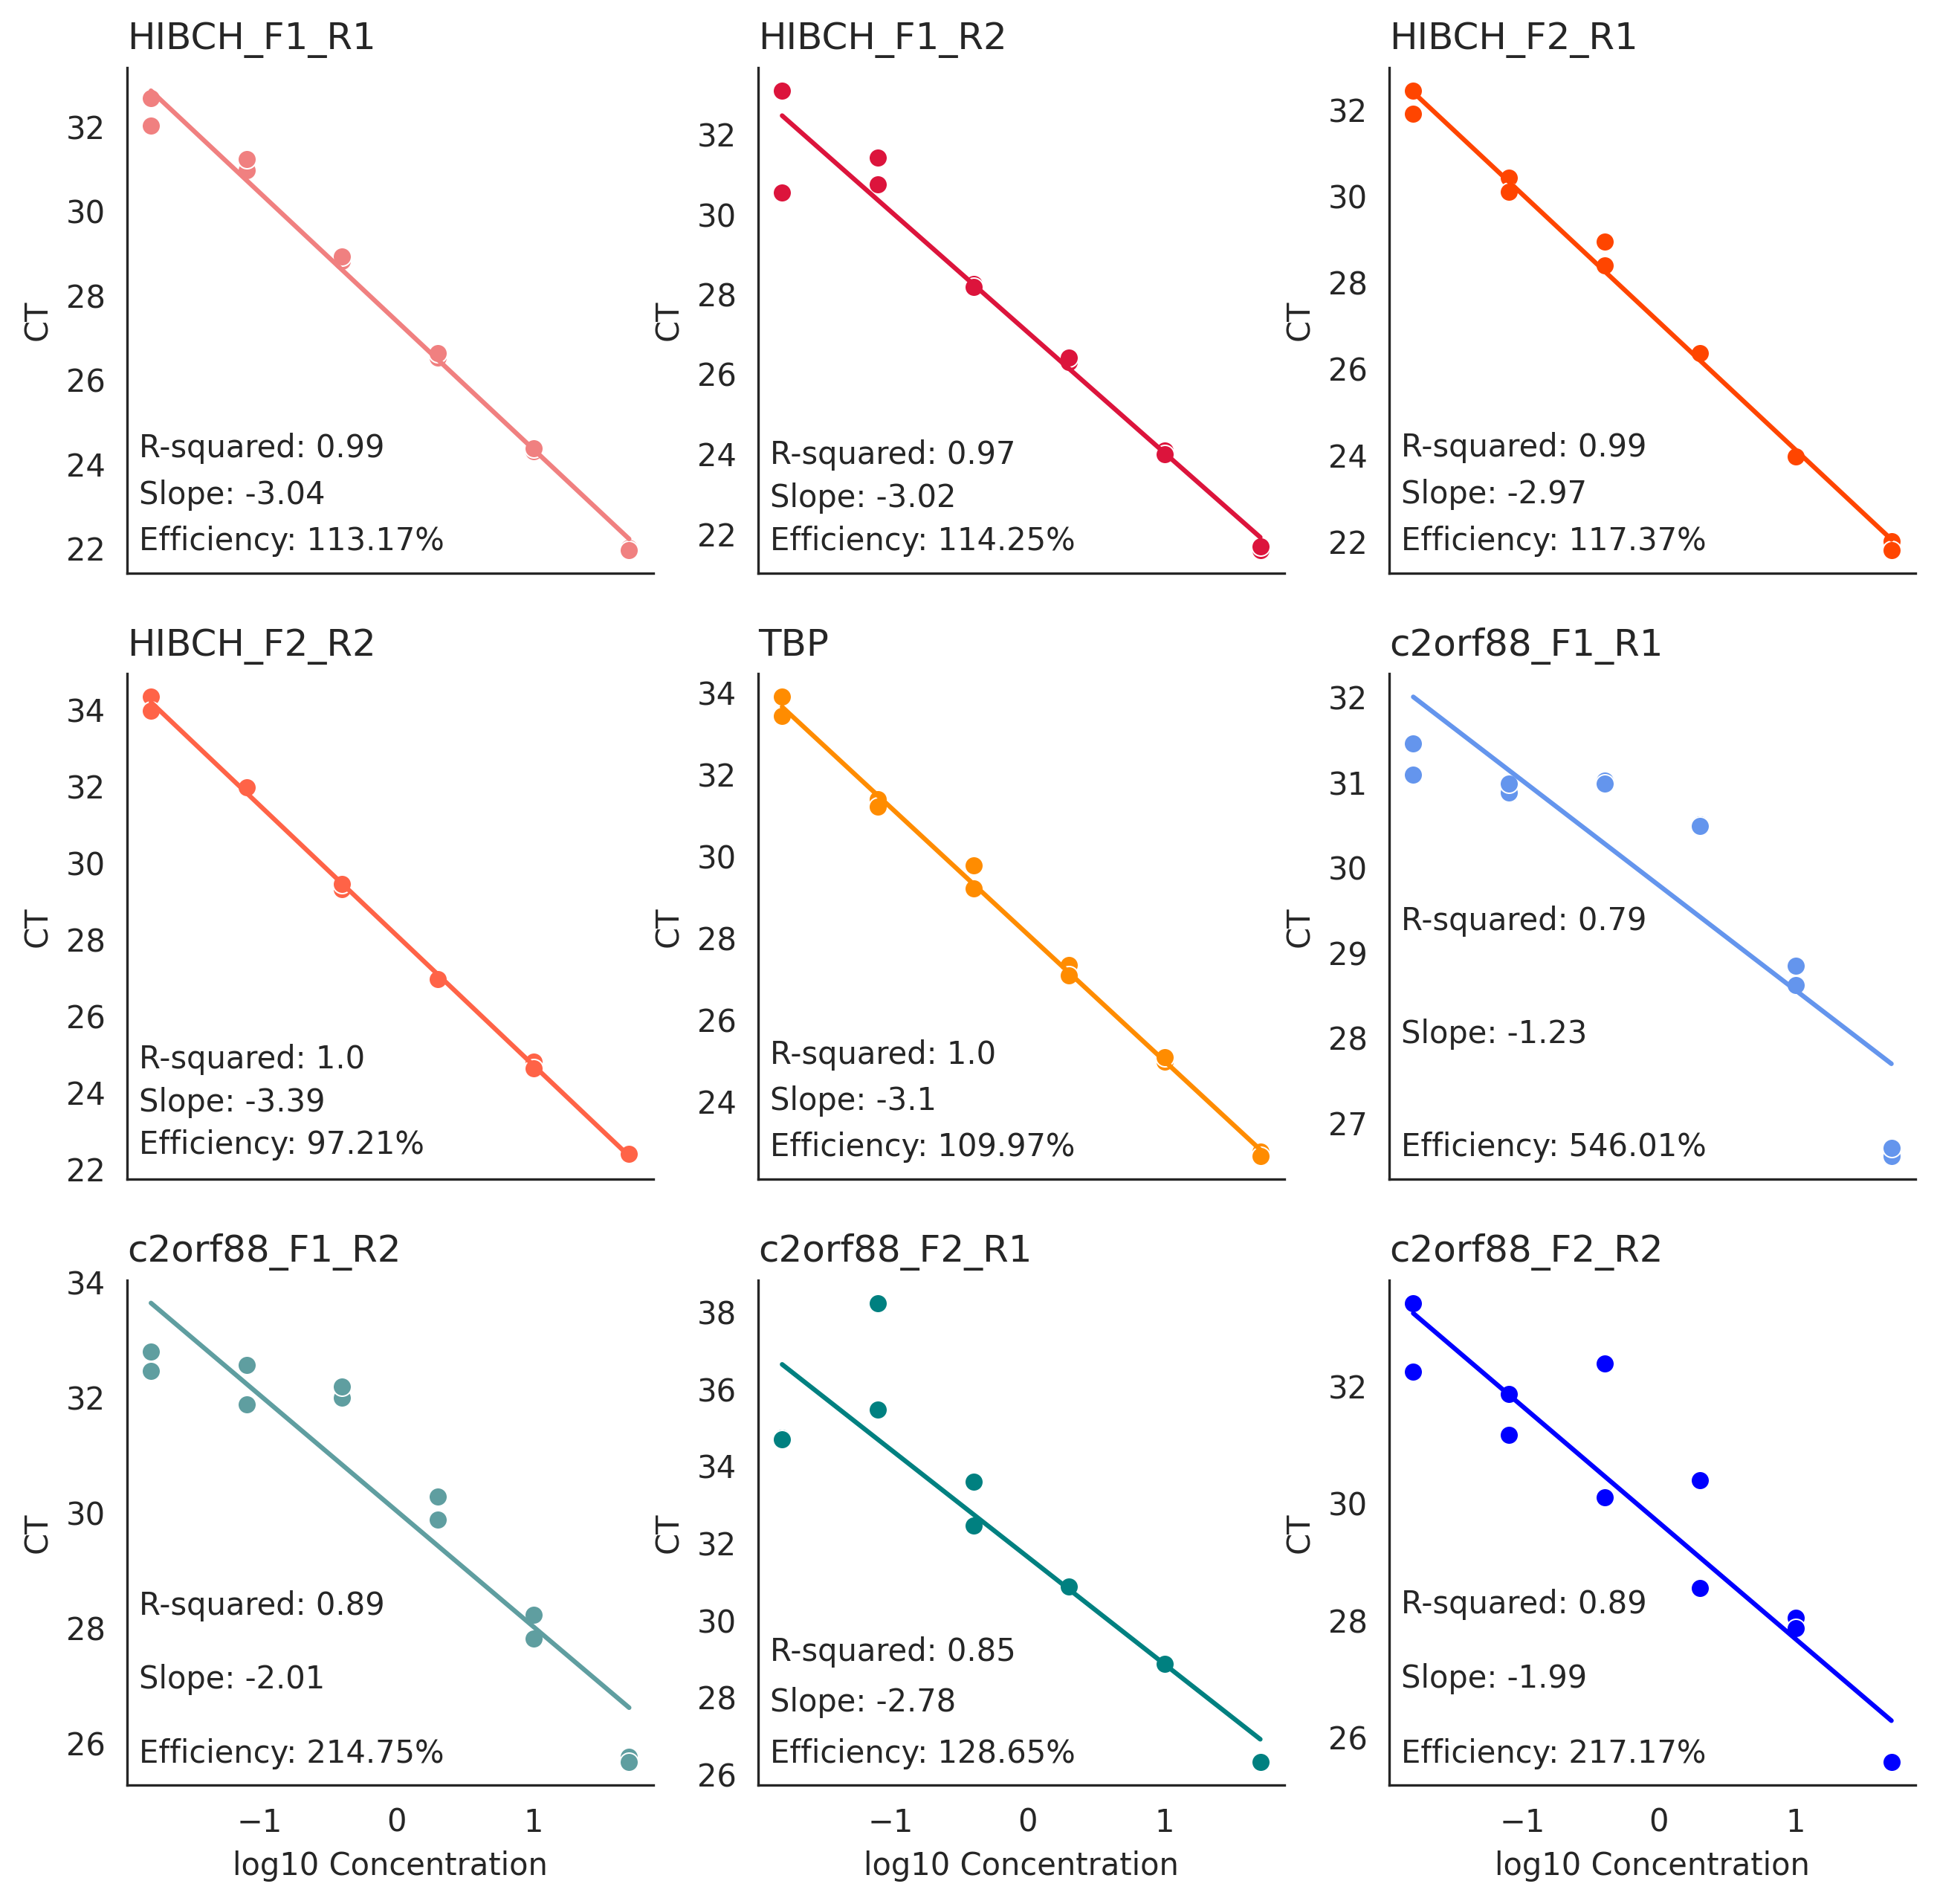

In [7]:
pur_pal = {'HIBCH_F1_R1' : 'lightcoral',
          'HIBCH_F1_R2' : 'crimson',
          'HIBCH_F2_R1' : 'orangered',
          'HIBCH_F2_R2' : 'tomato',
          'c2orf88_F1_R1' : 'cornflowerblue',
          'c2orf88_F1_R2' : 'cadetblue',
          'c2orf88_F2_R1' : 'teal',
          'c2orf88_F2_R2' : 'blue',
          'TBP' : 'darkorange'}
f = mpl.figure(figsize=(14,10),dpi=300)
gs = f.add_gridspec(3,4)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
row = 0
col = 0
# iterate through hibch
for i in luna_pur.sort_values(by='Target Name')['Target Name'].unique():
    with sns.axes_style('white'):
        ax = f.add_subplot(gs[row,col])
        # filter for only that sample
        samp_df = luna_pur[luna_pur['Target Name'] == i]
        sns.scatterplot(data=samp_df,
                        x='log10 Concentration',
                        y='CT',
                        color=pur_pal.get(i))
        # calculate linear regression
        reg = stats.linregress(samp_df['log10 Concentration'], samp_df['CT'])
        mpl.plot(samp_df['log10 Concentration'], reg.intercept + reg.slope*samp_df['log10 Concentration'], color=pur_pal.get(i))
        mpl.annotate(f'R-squared: {round(reg.rvalue**2,2)}', xy=(min(samp_df['log10 Concentration'])*1.05, min(samp_df['CT'])*1.1))
        mpl.annotate(f'Slope: {round(reg.slope,2)}', xy=(min(samp_df['log10 Concentration'])*1.05, min(samp_df['CT'])*1.05))
        mpl.annotate(f'Efficiency: {round((10**((-1/reg.slope)) - 1)*100,2)}%', xy=(min(samp_df['log10 Concentration'])*1.05, min(samp_df['CT'])))
        if row < 2:
            mpl.xticks([])
            mpl.xlabel('')
        #mpl.ylim(24,41)
        mpl.title(f'{i}', loc='left')
    col +=1
    if col == 3:
        row +=1
        col = 0
sns.despine()
mpl.savefig('031525_serial_dilution_pur_cDNA_pool_luna.pdf')

In [8]:
avg_fc_data = pd.read_csv(data_dir+"/Editing/final_qPCR_report_gata_luna.tsv",sep="\t")
# transform FC to log2FC
avg_fc_data['log2FC'] = [np.log2(i) for i in avg_fc_data['avg FC']]
avg_fc_data = avg_fc_data.sort_values(by=["Target Name", "Group", "Sample Name"])

In [9]:
# calculate Mann-Whitney for c2orf88
c2orf_mw, c2orf_mw_p = stats.mannwhitneyu(avg_fc_data[(avg_fc_data['Group'] == 'Base Edited') & # c2orf88 edited FCs
                                                      (avg_fc_data['Target Name'] == 'c2orf88')]['avg FC'],
                                          avg_fc_data[(avg_fc_data['Group'] == 'Reference') & # c2orf88 reference FCs
                                                      (avg_fc_data['Target Name'] == 'c2orf88')]['avg FC'])
c2orf_p_round = round(c2orf_mw_p,4)
# calculate Mann-Whitney for HIBCH
hibch_mw, hibch_mw_p = stats.mannwhitneyu(avg_fc_data[(avg_fc_data['Group'] == 'Base Edited') & # HIBCH edited FCs
                                                      (avg_fc_data['Target Name'] == 'HIBCH')]['avg FC'],
                                          avg_fc_data[(avg_fc_data['Group'] == 'Reference') & # HIBCH reference FCs
                                                      (avg_fc_data['Target Name'] == 'HIBCH')]['avg FC'])
hibch_p_round = round(hibch_mw_p, 4)

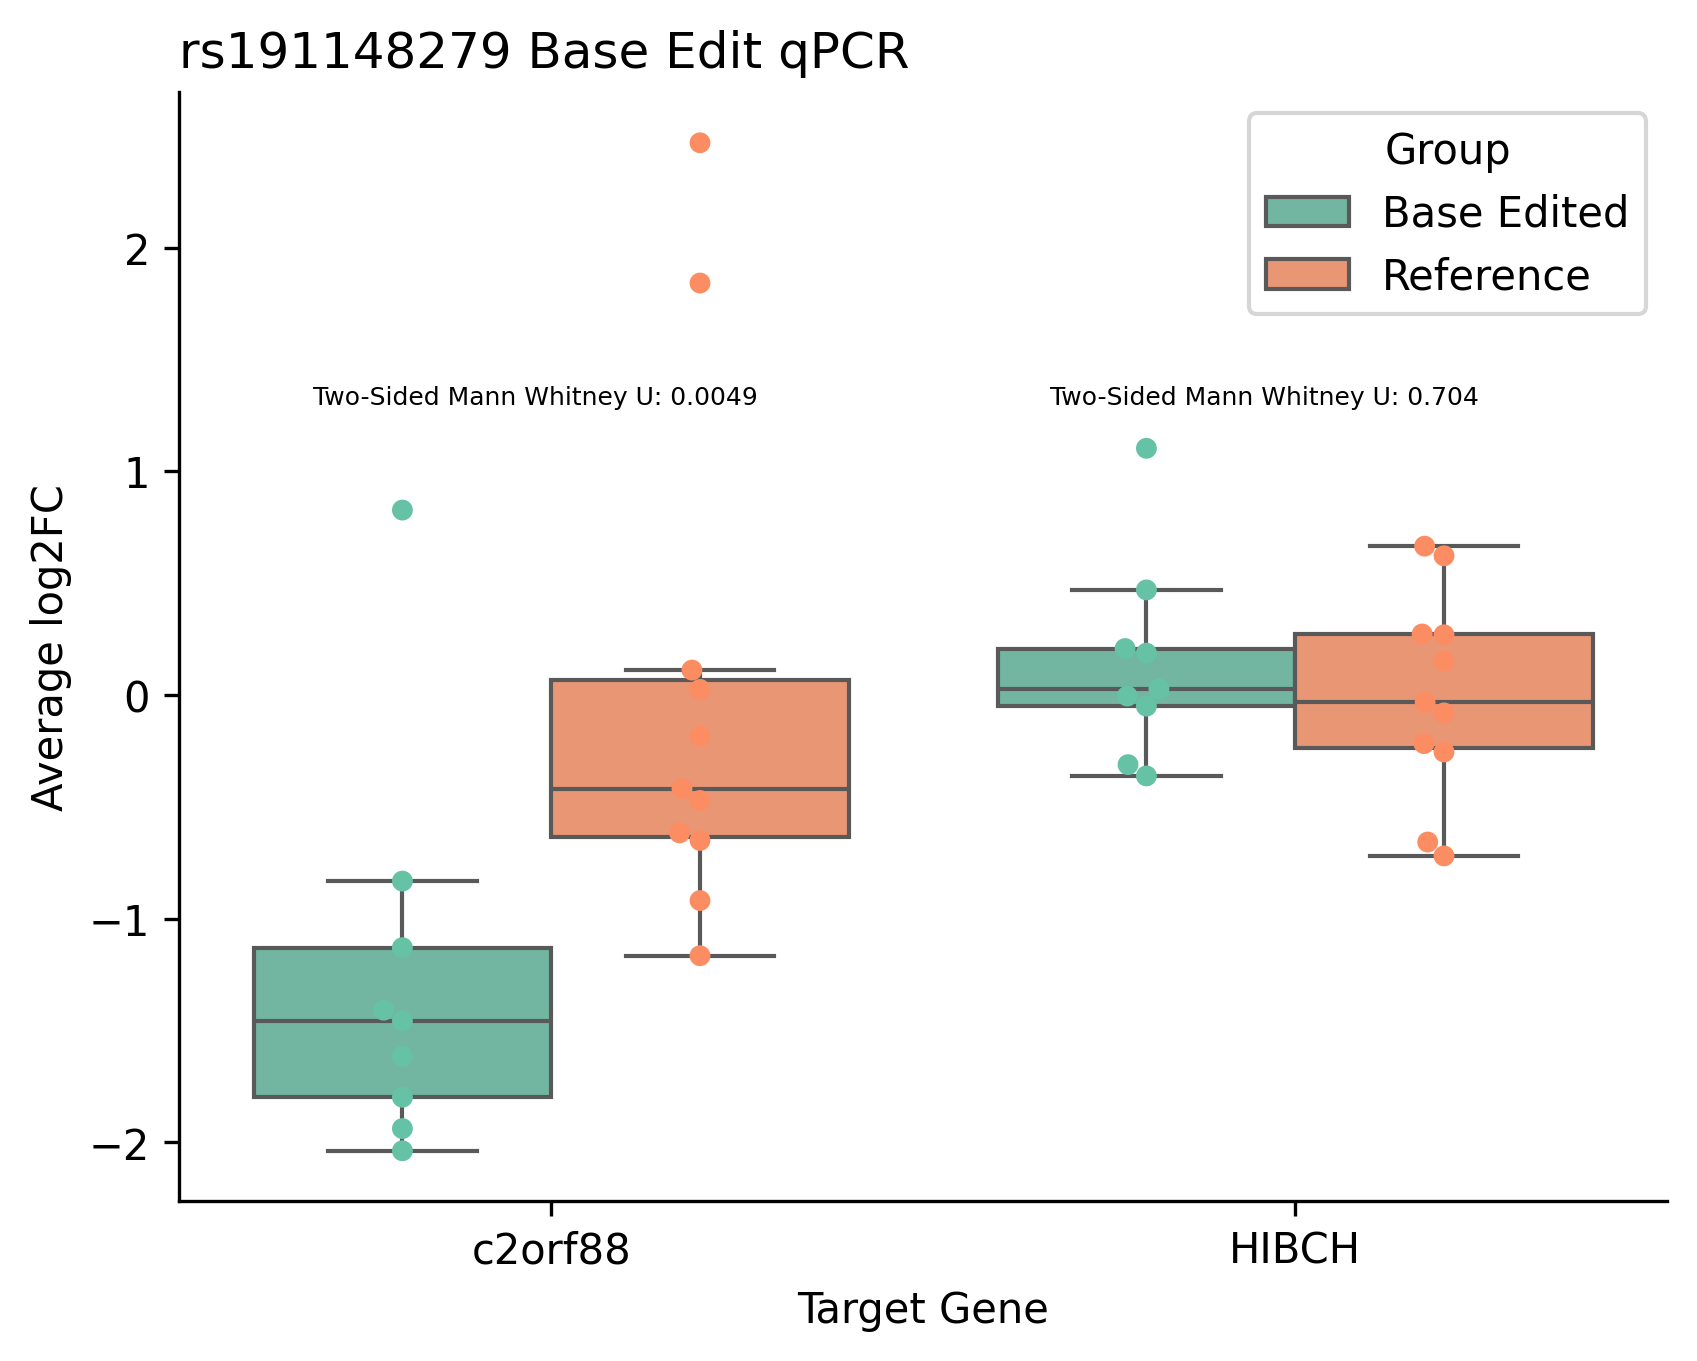

In [10]:
# makee box plot of groups #
mpl.figure(dpi=300)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

target_order = ["c2orf88", "HIBCH"]  # <-- or whatever genes you have

sns.boxplot(data=avg_fc_data.sort_values(by='Group'),
            x='Target Name',
            y='log2FC',
            hue='Group',
            showfliers=False,
            palette='Set2',
            order=target_order)
sns.swarmplot(data=avg_fc_data.sort_values(by='Group'),
            x='Target Name',
            y='log2FC',
            hue='Group',
            linewidth=0,
            dodge=True,
            legend=False,
            palette='Set2',
            order=target_order)
mpl.annotate(f'Two-Sided Mann Whitney U: {c2orf_p_round}',
             xy=(-.32, 1.3),
             size=6)
mpl.annotate(f'Two-Sided Mann Whitney U: {hibch_p_round}',
             xy=(.67, 1.3),
             size=6)
mpl.xlabel('Target Gene')
mpl.ylabel('Average log2FC')
mpl.title('rs191148279 Base Edit qPCR', loc='left')
sns.despine()
mpl.savefig('avg_log2fc_031825_and_032025_qpcrs_mann_whitney.pdf')